In [1]:
import sys
import requests
from bs4 import BeautifulSoup
!{sys.executable} -m pip install PyPDF2
from PyPDF2 import PdfReader
import re
import sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\agnes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Read in the UK-AU FTA, output a text for for each chapter, as well as an overall text file containing everything.

In [2]:
#pull free trade agreement links into a list
url = "https://www.gov.uk/government/collections/free-trade-agreement-between-the-united-kingdom-of-great-britain-and-northern-ireland-and-australia"
page = requests.get(url)
results = BeautifulSoup(page.content, "html.parser").find_all(class_ = "gem-c-document-list__item-title")

#filter to only look at chapters
chapters = [r for r in results if 'Chapter' in r.string]

#set up an empty string and an index
fta = ""
i = 0

#iterate through chapters
for c in chapters:
    #access the correct url
    doc_url = 'http://www.gov.uk' + c.get("href")
    doc_page = requests.get(doc_url)
    doc_soup = BeautifulSoup(doc_page.content, "html.parser")
    doc_result = doc_soup.find_all("h3")[4].find("a").get("href")
    
    #catch and fix an error with a specific chapter
    try:
        doc_response = requests.get(doc_result)
    except:
        doc_response = requests.get(doc_soup.find_all("h3")[5].find("a").get("href"))
    
    #pull out the chapter's PDF
    pdf = open("C:/Users/agnes/Documents/Masters Files/Year 3/Temp PDFs/"  + str(i) + "doc.pdf", "wb+")
    pdf.write(doc_response.content)
    chptPdf = PdfReader("C:/Users/agnes/Documents/Masters Files/Year 3/Temp PDFs/" + str(i) + "doc.pdf")
    
    #work through all the pages in each chapter, converting them to text
    n = chptPdf.numPages
    chpt = ""
    for p in range(n):
        text = chptPdf.pages[p]
        clean_page = text.extract_text().strip()
        #remove page numbers
        clean_page = re.sub("[0-9][0-9]*-[0-9][0-9]*", " ", clean_page)
        #add the page to the chapter
        chpt += clean_page
    
    #write the chapter out as a text file
    text_file = open("C:/Users/agnes/Documents/Masters Files/Year 3/Text Data/" + str(i) + "doc.txt", "w", encoding="utf-8")
    text_file.write(chpt)
    text_file.close()
    
    #add the chapter to the overall fta and add to the index
    fta += chpt
    i += 1

#write out the overall fta as a text file
text_file = open("C:/Users/agnes/Documents/Masters Files/Year 3/UK-AU-FTA.txt", "w", encoding="utf-8")
text_file.write(fta)
text_file.close()

### Stem and Tokenise Text for Analysis

In [3]:
#create list of chapter texts
fta_chapters = []
for i in range(len(chapters)):
    #read in chapter
    chpt = open("C:/Users/agnes/Documents/Masters Files/Year 3/Text Data/" + str(i) + "doc.txt", "r", encoding = "utf-8").read()
    #remove numbers and roman numerals
    chpt = re.sub("[0-9]", "", chpt)
    chpt = re.sub("^M{0,4}(cm|cd|d?c{0,3})(xc|xl|l?x{0,3})(ix|iv|v?i{0,3})$", "", chpt)
    fta_chapters.append(chpt)

#set up stop words to use in this case and add some general ones
stop_words = ['chapter', 'article', 'becau']
stop_words.extend(stopwords.words('english'))
    
#use sklearn CountVectorizer to create document-term matrix
count_vect = CountVectorizer(stop_words = stop_words)
x_counts = count_vect.fit_transform(fta_chapters)
#output this in a pretty format
df_bow_sklearn = pd.DataFrame(x_counts.toarray(), columns = count_vect.get_feature_names_out())
df_bow_sklearn.head()

,abandoned,abatement,abetting,abilities,ability,able,abnormally,abolishing,abolition,aboriginal,...,𝑖𝑖,𝑚𝑚𝑣𝑣𝑡𝑡𝑣𝑣𝑜𝑜,𝑛𝑛𝑜𝑜𝑛𝑛,𝑜𝑜𝑜𝑜,𝑜𝑜𝑜𝑜𝑜𝑜𝑔𝑔𝑜𝑜𝑛𝑛𝑣𝑣𝑡𝑡𝑜𝑜𝑛𝑛𝑔𝑔,𝑜𝑜𝑣𝑣𝑣𝑣𝑚𝑚,𝑡𝑡ℎ𝑣𝑣,𝑣𝑣𝑣𝑣,𝑣𝑣𝑣𝑣𝑣𝑣,𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,1,5,2,2,3,1,1,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see which words are used in the first five chapters. Even having removed stopwords there are still many unique words in the agreement, leading to this not being very informative. There are several improvements we can look to make, looking at the roots of words, removing words that don't appear in more than one chapter and seeing if we can combine any words.

In [4]:
#firstly, some words clearly have the same roots and meanings, we can combine them by pre-processing text with a stemmer
ps = PorterStemmer()
def preprocess(text):
    text = text.lower() 
    #remove special characters
    text = re.sub("\\W", " ", text) 
    #stem words
    words = re.split("\\s+", text)
    stemmed_words = [ps.stem(word = word) for word in words]
    return ' '.join(stemmed_words)
#update stop words to catch any that have been stemmed
stop_words.extend([ps.stem(word = word) for word in stop_words])

#use this in vectoriser to create document-term matrix, also remove words that only appear in one chapter
clean_count_vect = CountVectorizer(stop_words = stop_words, preprocessor = preprocess, min_df = 2)
clean_x_counts = clean_count_vect.fit_transform(fta_chapters)
df_bow_sklearn = pd.DataFrame(clean_x_counts.toarray(), columns = clean_count_vect.get_feature_names_out())
df_bow_sklearn.head()

,abandon,abet,abil,abl,aborigin,absenc,absolut,academ,acceler,accept,...,workshop,world,would,write,written,wto,year,yet,york,zone
0,0,0,0,0,0,3,0,0,0,1,...,0,2,0,0,0,14,0,0,0,2
1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,1,1,8,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,3,2,6,2,6,0,0,0
3,0,0,0,0,0,0,0,0,0,4,...,0,0,4,2,10,0,8,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,2,2,4,0,1,0,0,0


In [5]:
#need to see if there are combinations of words that can be counted as one, i.e. compound tokens, e.g. Data Science
#do this by looking at n-grams (2 to 8 words) and view only the 10 most popular
bigram_count_vect = CountVectorizer(stop_words = stop_words, preprocessor = preprocess, min_df = 2, ngram_range = (2,8), 
                                    max_features = 20)
x_bigram_counts = bigram_count_vect.fit_transform(fta_chapters)
df_bow_sklearn = pd.DataFrame(x_bigram_counts.toarray(), columns = bigram_count_vect.get_feature_names_out())
df_bow_sklearn.head()

,cross border,financi servic,financi servic supplier,good servic,greater certainti,import parti,intellectu properti,law regul,nation treatment,parti may,parti parti,parti recognis,parti shall,parti shall ensur,parti shall provid,servic supplier,shall ensur,shall provid,state enterpris,territori parti
0,0,0,0,3,4,0,1,6,0,1,4,0,2,0,0,0,0,0,1,0
1,0,0,0,0,3,3,0,1,2,4,4,0,25,2,0,0,2,0,0,7
2,0,0,0,0,0,6,0,1,0,4,0,0,14,1,5,0,1,8,0,2
3,0,0,0,0,4,37,0,8,0,10,2,0,30,1,12,0,1,12,0,12
4,0,0,0,0,3,5,0,20,0,9,5,0,50,8,6,0,8,8,0,2


In [6]:
#use some of these as compound tokens within the tokenisation, some should be added to stopwords
stop_words.extend(['parti', 'shall', 'may', 'paragraph'])
def preprocess(text):
    text = text.lower() 
    #remove special characters and stop words
    text = re.sub("\\W"," ",text) 
    text=re.sub("\\s+(cross border)\\s+","cross_border",text)
    text=re.sub("\\s+(financial service)","financial_servics",text)
    text=re.sub("\\s+(intellectual property)\\s+","intellectual_property",text)
    text=re.sub("\\s+(united kingdom)\\s+","united_kingdom",text)
    text=re.sub("\\s+(contact point)\\s+","contact_point",text)
    text=re.sub("\\s+(non conforming)\\s+","non_conforming",text)
    #stem words
    words = re.split("\\s+",text)
    stemmed_words = [ps.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

#run n-grams again to see if there is anything else
compound_count_vect = CountVectorizer(stop_words = stop_words, preprocessor = preprocess, min_df = 2, ngram_range = (2,10), 
                                    max_features = 20)
x_compound_counts = compound_count_vect.fit_transform(fta_chapters)
df_bow_sklearn = pd.DataFrame(x_compound_counts.toarray(), columns = compound_count_vect.get_feature_names_out())
df_bow_sklearn.head()

,adopt maintain,compet author,cover invest,cross border,disput settlement,entri forc,entri forc agreement,forc agreement,good servic,greater certainti,law regul,nation treatment,network servic,non commerci,public telecommun,recognis import,servic supplier,state enterpris,trade invest,work group
0,1,0,1,0,1,3,3,3,3,4,6,0,0,0,0,0,0,1,0,0
1,7,0,0,0,2,4,2,2,0,3,1,2,0,0,0,0,0,0,0,4
2,0,4,0,0,3,2,2,2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,4,4,4,0,4,8,0,0,0,0,0,0,0,0,6
4,8,0,0,0,0,0,0,0,0,3,20,0,0,0,0,0,0,0,0,3


Having finished our manipulations with tokenisation and pre-processing, we can create a final document-term matrix.

In [7]:
#use stopwords and preprocess function as developed, set a minimum of two chapters for a token to appear)
final_count_vect = CountVectorizer(stop_words = stop_words, preprocessor = preprocess, min_df = 2)
x_final_counts = final_count_vect.fit_transform(fta_chapters)
df_bow_sklearn = pd.DataFrame(x_final_counts.toarray(), columns = final_count_vect.get_feature_names_out())
df_bow_sklearn.head()

,abandon,abet,abil,abl,aborigin,absenc,absolut,academ,acceler,accept,...,workshop,world,would,write,written,wto,year,yet,york,zone
0,0,0,0,0,0,3,0,0,0,1,...,0,2,0,0,0,14,0,0,0,2
1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,1,1,8,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,3,2,6,2,6,0,0,0
3,0,0,0,0,0,0,0,0,0,4,...,0,0,4,2,10,0,8,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,2,2,4,0,1,0,0,0


In [8]:
#for the sake of having something presentable, we make a DTM of the most used words
df_bow_sklearn.loc[:, df_bow_sklearn.sum(axis=0) > 400]

,agreement,good,includ,inform,measur,provid,requir,servic,supplier,trade
0,59,15,15,1,12,4,1,6,0,16
1,23,63,12,6,13,13,10,1,1,16
2,20,25,4,3,46,17,0,0,0,7
3,9,188,34,39,1,57,44,0,3,16
4,4,63,17,28,6,40,22,1,0,21
5,17,3,13,23,52,26,17,0,0,20
6,15,5,12,18,5,11,20,0,3,17
7,11,3,25,17,47,12,42,114,24,10
8,15,16,64,46,68,26,55,94,111,37
9,6,1,17,3,4,6,5,52,5,8


### Bag of Words Analysis

We now run some bag-of-words analysis on this data. Beginning with how frequently words appear, through the entire text and in how many chapters.

In [9]:
#get the usage of tokens, then combine into df
freqs = df_bow_sklearn.sum(axis = 0)
docfreqs = np.count_nonzero(df_bow_sklearn, axis = 0)

token_freq = pd.DataFrame(dict(frequency = freqs, doc_frequency = docfreqs), index = final_count_vect.get_feature_names_out())
largest_tokens = token_freq.nlargest(20, 'frequency')
largest_tokens

,frequency,doc_frequency
includ,689,32
servic,649,22
provid,631,30
good,630,26
measur,612,27
agreement,513,32
inform,503,29
trade,498,32
requir,413,25
supplier,412,13


An interesting result with a big variation in document frequency, even the second most common token is featured in 8 fewer chapters than the most frequent.

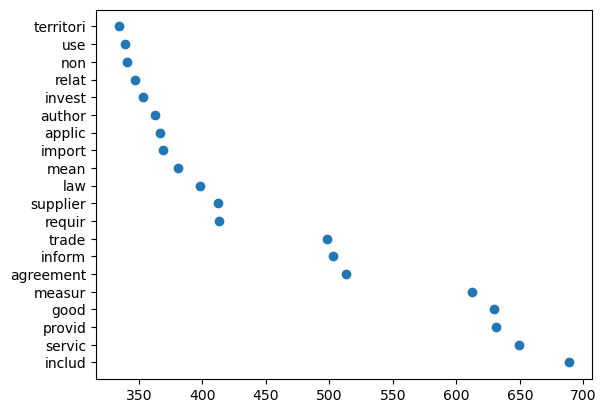

In [10]:
plt.scatter(largest_tokens.frequency, largest_tokens.index.values)
plt.show()

So a pretty sharp drop away from the most commonlly used word, although perhaps includ should be in our stopwords? We won't get too bogged down in this.

Beyond just the most common words, we can also consider how lexically diverse chapters are.

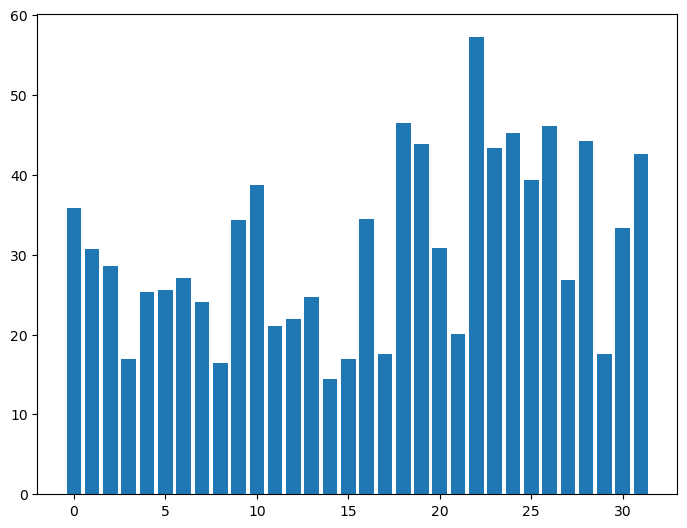

In [11]:
#calculate type-token ration
types = df_bow_sklearn.astype(bool).sum(axis = 1)
tokens = df_bow_sklearn.sum(axis = 1)
ttr = 100 * (types / tokens)
ttr_df = pd.DataFrame({'chapter':ttr.index, 'ttr':ttr.values})
#visualise this
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ttr_df.chapter, ttr_df.ttr)
plt.show()

High values indicate high lexical diversity. There is a big variation between different chapters, with perhaps a slight increase for later chapters. But how does this equate to actual meaning? We can consider this using sentiment analysis.

In [12]:
sia = SentimentIntensityAnalyzer()
[sia.polarity_scores(chpt) for chpt in fta_chapters]

[{'neg': 0.008, 'neu': 0.774, 'pos': 0.218, 'compound': 0.9999},
 {'neg': 0.019, 'neu': 0.826, 'pos': 0.155, 'compound': 0.9998},
 {'neg': 0.053, 'neu': 0.713, 'pos': 0.234, 'compound': 0.9999},
 {'neg': 0.019, 'neu': 0.785, 'pos': 0.196, 'compound': 1.0},
 {'neg': 0.028, 'neu': 0.843, 'pos': 0.129, 'compound': 0.9999},
 {'neg': 0.022, 'neu': 0.782, 'pos': 0.196, 'compound': 1.0},
 {'neg': 0.014, 'neu': 0.852, 'pos': 0.135, 'compound': 0.9998},
 {'neg': 0.019, 'neu': 0.798, 'pos': 0.183, 'compound': 1.0},
 {'neg': 0.025, 'neu': 0.797, 'pos': 0.178, 'compound': 1.0},
 {'neg': 0.014, 'neu': 0.822, 'pos': 0.164, 'compound': 0.9998},
 {'neg': 0.034, 'neu': 0.813, 'pos': 0.153, 'compound': 0.9992},
 {'neg': 0.016, 'neu': 0.848, 'pos': 0.136, 'compound': 0.9999},
 {'neg': 0.028, 'neu': 0.781, 'pos': 0.191, 'compound': 1.0},
 {'neg': 0.023, 'neu': 0.781, 'pos': 0.196, 'compound': 1.0},
 {'neg': 0.046, 'neu': 0.757, 'pos': 0.197, 'compound': 1.0},
 {'neg': 0.025, 'neu': 0.863, 'pos': 0.112, 'c

We don't need to visualise these to see that the negiative scores are universally small with the positive scores are far higher. This is reflected in the overall compound measurement, typically 0.5 is the boundary for positive text, but these scores are far above that. The sentiment of this text seems to overwhelmingly positive.

Finally, we can consider whether there are any topics within the text that can be found. We assume there are 3.

In [13]:
model = LatentDirichletAllocation(n_components = 3)
lda_matrix = model.fit_transform(x_final_counts)
lda_components = model.components_
terms = final_count_vect.get_feature_names_out()
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['servic', 'good', 'supplier', 'provid', 'includ', 'measur', 'procur']
Topic 1:  ['provid', 'law', 'right', 'protect', 'panel', 'author', 'agreement']
Topic 2:  ['agreement', 'trade', 'measur', 'includ', 'cooper', 'import', 'committe']


This gives us 3 distinct topics (more and they become less distinct). The first seems to be about about the trade of goods, which includes their origin. The second about the general agreement, highlighting the cooperation and what will be included. The final seemingly about the trade of services, defining what is required and included, what measures are in place for suppliers etc.